In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scipy.stats as st
import scipy.integrate as si
import scipy.signal as ss
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from collections import defaultdict
import pandas as pd
import pathlib
from causal_optoconnectics.core import find_response_spikes
from causal_optoconnectics.buzsaki import transfer_probability
import causal_optoconnectics as co

%matplotlib inline

In [3]:
# base_path = pathlib.Path('/home/mikkel/data/data_branched_stim_idstsswitched')
base_path = pathlib.Path('/home/jovyan/work/instrumentalVariable/data_intermed/')

In [4]:
connections = np.load(base_path / 'm.npz', allow_pickle=True)['m'][()]

In [5]:
N = connections.shape[0]

In [6]:
df = pd.DataFrame([
    (j, i, connections[i, j]) for i in range(N) for j in range(N) if i!=j],
    columns=['source', 'target', 'weight']
)

In [7]:
paths = [path for path in base_path.iterdir() if path.is_dir()]
paths = sorted(paths, key=lambda x: int(x.stem))

In [8]:
i = 0
cch = []

t_br = 0.014 # seconds, length of branch
t_int = 0.03 # second, length of pause between branches

for i_core in range(20):
    print(i_core)
    path  = paths[i_core]
    try:
        spks = np.load(path / 'spks1.npz', allow_pickle=True)['data'][()]

        spks_ts = spks['spk_ts']/1000
        spks_ids = spks['spk_ids']

        brs_dat = []
        brs_t = []
        for fname in path.glob('stimulation_data*.npz'):
            data = np.load(fname, allow_pickle=True)['data'][()]
            br_t = data['t']/1000
            brs_t.append(br_t)
            brs_dat.append(data)

        brs_dat = np.array(brs_dat)
        brs_t = np.array(brs_t)
        ids_sort = np.argsort(brs_t)

        brs_t = brs_t[ids_sort]
        brs_dat = brs_dat[ids_sort]

        ts_all = []
        ids_all = []

        brs_t = [0.]  # previous branch
        for data_i in brs_dat:
            # get time of branch
            br_t = data_i['t']/1000

            # get all spikes from since end of last branch
            bl_i = (spks_ts >= brs_t[-1]) & (spks_ts < br_t)
            ts_i = spks_ts[bl_i]
            ids_i = spks_ids[bl_i]

            # add spikes from current branch
            ts_br = data_i['spk_ts']/1000
            ids_br = data_i['spk_ids']

            ts_i = np.concatenate((ts_i, ts_br))
            ids_i = np.concatenate((ids_i, ids_br))

            brs_t.append(br_t)

            ts_all.append(ts_i)
            ids_all.append(ids_i)


        ls_shftd = []
        for i, br_t in enumerate(brs_t[:-1]):
            ls_shftd.append(ts_all[i]+i*(t_int+t_br))

        ts_shftd = np.concatenate(ls_shftd)
        ids_shftd = np.concatenate(ids_all)

        for i in range(1000):
            bl_i = ids_shftd==i
            ts_i = ts_shftd[bl_i]
            cch_i, bins = co.cch.correlogram(ts_i, auto=True)
            cch.append(cch_i)
    except:
        print('skip '+str(i_core))
        pass


0
1
2
4
5
6
7
8
9
10
11
12
13
14
15
16
17
skip 17
18
19


In [9]:
cch_max = np.max(np.array(cch), axis=0)

(0, 4)

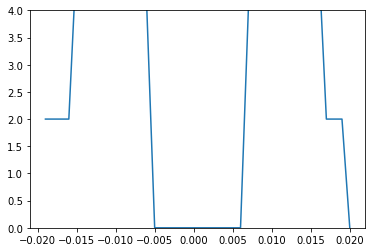

In [11]:
plt.plot(bins[1:], cch_max)
plt.ylim(0, 4)